In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%pylab inline
import seaborn as sns
import statsmodels.formula.api as smf
from sklearn.cross_validation import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### multiple dwelling registration

You can find Multiple Dwelling Registration data including OwnerTypes and Site Manager information from the attached file. Followings are the description of columns:
* Owner: There is only 0. All BBLs of this data is living without owner in their buildings
* Ownership: Types of specific owners
    * Corp: Corporation (each unit is owned by individual owner)
    * Ind: Individual Owner
    * Off: Owned by company
    * Joint: Shared Owner (multiple owners)
    * Agent: Yes or No of representative agent of the building
    * SiteManager: Yes or No of site manager (super)
There are some NaN in "Agent" and "SiteManager" columns. 

You can replace those as 0 or drop. The results (before dropping and after dropping) were not that different. 

In [2]:
dwell = pd.read_csv('../data_processed/Multiple_Dwelling_Registration_OwnerType_Boiler_Joined.csv')
dwell = dwell.drop('Unnamed: 0',axis=1)
dwell.head()

,BBL,Owner,Ownership,Agent,SiteManager,boiler,boiler_age
0,4086640052,0,Ind,0.0,1.0,0,27.174765
1,4057400139,0,Corp,1.0,1.0,0,27.174765
2,3034570006,0,Corp,1.0,1.0,0,27.174765
3,1021160061,0,Corp,1.0,1.0,0,27.174765
4,1004360020,0,Corp,1.0,1.0,0,27.174765


In [3]:
dwell.boiler.unique()

array([0, 1, 2])

In [4]:
len(dwell)

147075

In [5]:
dwell = dwell.dropna()
dwell = dwell.drop('Owner',axis=1)

In [6]:
len(dwell)

144838

In [7]:
dwell.Ownership.unique()

array(['Ind', 'Corp', 'Off', 'Joint'], dtype=object)

In [8]:
dwell = pd.concat([dwell, pd.get_dummies(dwell['Ownership'])],axis=1)
dwell = pd.concat([dwell, pd.get_dummies(dwell['boiler'],prefix='boiler')],axis=1)

In [9]:
###drop boiler_0, and Corp to use as reference columns
dwell = dwell.drop(['Ownership', 'boiler', 'boiler_0', 'Corp'],axis=1)

In [10]:
dwell.head()

,BBL,Agent,SiteManager,boiler_age,Ind,Joint,Off,boiler_1,boiler_2
0,4086640052,0.0,1.0,27.174765,1,0,0,0,0
1,4057400139,1.0,1.0,27.174765,0,0,0,0,0
2,3034570006,1.0,1.0,27.174765,0,0,0,0,0
3,1021160061,1.0,1.0,27.174765,0,0,0,0,0
4,1004360020,1.0,1.0,27.174765,0,0,0,0,0


### pluto

mapPLUTO
* AssessSqft
* UnitsRes
* ResArea
* ResArea_perunit
* Res_r
* NumFloors
* Bldg_nrr
* Bldg_age
* BsmtCode
* ProxCode
* BldgClass_dummy

In [11]:
pluto = pd.read_csv('../data_processed/pluto_16')
pluto = pluto.drop('Unnamed: 0',axis=1)
pluto.head()

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (27,37,40,46,53,64,65,84,85) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap,geometry
0,0.0,NaN,437 PURDY AVENUE,R3-1,NaN,7,15120.0,23400.0,5.007470e+09,1488,...,0,1960,NaN,10314,R3-1,NaN,NaN,NaN,20d,"POLYGON ((944681.4200000018 161477.381400004, ..."
1,0.0,NaN,CUNARD AVENUE,R3A/HS,NaN,4,21518.0,21518.0,5.006230e+09,0,...,0,0,NaN,10304,R3A,NaN,NaN,NaN,21d,"POLYGON ((959872.0577999949 162992.5866000056,..."
2,0.0,NaN,121 MOUNTAINVIEW AVENUE,R3-1,NaN,7,13561.0,22602.0,5.007130e+09,1316,...,0,1920,NaN,10314,R3-1,NaN,NaN,NaN,21b,"POLYGON ((949278.1987999976 161346.9971999973,..."
3,0.0,NaN,26 FANNING STREET,R3X,NaN,7,9720.0,28740.0,5.007140e+09,2188,...,0,1975,NaN,10314,R3X,NaN,NaN,NaN,21b,"POLYGON ((950061.0491999984 160815.3023999929,..."
4,0.0,NaN,335 SIMONSON AVENUE,R3A,NaN,7,7617.0,22118.0,5.011840e+09,2392,...,0,1965,NaN,10303,R3A,NaN,NaN,NaN,20c,"POLYGON ((941981.4906000048 168120.2173999995,..."


#### remove outliers

In [12]:
pluto = pluto[pluto['YearBuilt']>1750]
pluto = pluto[pluto['AssessLand']> 0]
pluto = pluto[pluto['NumBldgs'] > 0]
pluto = pluto[pluto['NumFloors'] > 0]
pluto = pluto[pluto['ResArea'] > 0]
pluto = pluto[pluto['UnitsRes'] < 8000]
pluto = pluto[pluto['UnitsRes'] > 0]
pluto = pluto[pluto['BldgFront'] > 0]

#### adjust features

In [13]:
pluto['AssessSqft'] = pluto['AssessTot']/pluto['BldgArea']
pluto = pluto[pluto['AssessSqft'] > 0]

pluto['BldgAge'] = 2017-pluto['YearBuilt']
pluto = pluto.drop('YearBuilt',axis=1)

pluto['Bldg_nrr'] = pluto['BldgDepth']/pluto['BldgFront'].astype(float)

#proxcode
#0 = unknown, 1 = detatched, 2 = attached or semi=attached
pluto['ProxCode'] = pluto['ProxCode'].replace(3, 2)

#bsmtcode
#0 = no basement, 1 = full or partial basement, 5 = unknown
pluto['BsmtCode'] = pluto['BsmtCode'].replace(2, 1)
pluto['BsmtCode'] = pluto['BsmtCode'].replace(3, 1)
pluto['BsmtCode'] = pluto['BsmtCode'].replace(4, 1)
pluto['Res_r'] = pluto['ResArea']/pluto['BldgArea'].astype(float)
pluto['ResArea_perunit'] = pluto['ResArea']/pluto['UnitsRes'].astype(float)

bldgclass = []
for elem in pluto['BldgClass']:
    bldgclass.append(str(elem[0]))
bldgclasscat = []
for elem in bldgclass:
    if elem == 'A':
        bldgclasscat.append(1)
    elif elem == 'B':
        bldgclasscat.append(2)
    elif elem == 'C':
        bldgclasscat.append(3)
    elif elem == 'S':
        bldgclasscat.append(3)
    elif elem == 'D':
        bldgclasscat.append(4)
    elif elem == 'O8':
        bldgclasscat.append(4)
    elif elem == 'R':
        bldgclasscat.append(5)
    elif elem == 'L':
        bldgclasscat.append(6) 
    else:
        bldgclasscat.append(0)
pluto['BldgClass_dummy'] = bldgclasscat

In [14]:
pluto = pd.concat([pluto, pd.get_dummies(pluto['BldgClass_dummy'], prefix='bc'), \
                    pd.get_dummies(pluto['ProxCode'], prefix='pc'), \
                   pd.get_dummies(pluto['BsmtCode'], prefix='bsmt')],axis=1)

proxcode = []
for elem in pluto['ProxCode']:
    proxcode.append(elem)
proxcodecat = []
for elem in proxcode:
    if elem == 0:
        proxcodecat.append('pc0')
    elif elem == 1:
        proxcodecat.append('pc1')
    elif elem == 2:
        proxcodecat.append('pc2')
pluto['ProxCode_dummy'] = proxcodecat

bsmtcode = []
for elem in pluto['BsmtCode']:
    bsmtcode.append(elem)
bsmtcodecat = []
for elem in bsmtcode:
    if elem == 0:
        bsmtcodecat.append('bsmt0')
    elif elem == 1:
        bsmtcodecat.append('bsmt1')
    elif elem == 5:
        bsmtcodecat.append('bsmt5')
pluto['BsmtCode_dummy'] = bsmtcodecat

BldgClass
 1: A (one family housing)
 2: B (two family housing)
 3: C + S (walk up + mixed use)
 4: D + O8 (elevator apartment + apt with office)
 5: R (condominium)
 6: L (loft)
 0: Others

In [15]:
pluto.head(2)

,APPBBL,APPDate,Address,AllZoning1,AllZoning2,AreaSource,AssessLand,AssessTot,BBL,BldgArea,...,bc_3,bc_4,bc_5,bc_6,pc_0.0,pc_1.0,pc_2.0,bsmt_0.0,bsmt_1.0,bsmt_5.0
0,0.0,NaN,437 PURDY AVENUE,R3-1,NaN,7,15120.0,23400.0,5.007470e+09,1488,...,0,0,0,0,0,1,0,0,1,0
2,0.0,NaN,121 MOUNTAINVIEW AVENUE,R3-1,NaN,7,13561.0,22602.0,5.007130e+09,1316,...,0,0,0,0,0,1,0,0,1,0


In [16]:
pluto.columns[20:]

Index([u'CD', u'CT2010', u'ComArea', u'CommFAR', u'CondoNo', u'Council',
       u'EDesigNum', u'Easements', u'ExemptLand', u'ExemptTot', u'Ext',
       u'FacilFAR', u'FactryArea', u'FireComp', u'GarageArea', u'HealthArea',
       u'HistDist', u'IrrLotCode', u'LandUse', u'Landmark', u'Lot', u'LotArea',
       u'LotDepth', u'LotFront', u'LotType', u'LtdHeight', u'MAPPLUTO_F',
       u'NumBldgs', u'NumFloors', u'OfficeArea', u'OtherArea', u'Overlay1',
       u'Overlay2', u'OwnerName', u'OwnerType', u'PLUTOMapID', u'PolicePrct',
       u'ProxCode', u'ResArea', u'ResidFAR', u'RetailArea', u'SHAPE_Area',
       u'SHAPE_Leng', u'SPDist1', u'SPDist2', u'Sanborn', u'SchoolDist',
       u'SplitZone', u'StrgeArea', u'TaxMap', u'Tract2010', u'UnitsRes',
       u'UnitsTotal', u'Version', u'XCoord', u'YCoord', u'YearAlter1',
       u'YearAlter2', u'ZMCode', u'ZipCode', u'ZoneDist1', u'ZoneDist2',
       u'ZoneDist3', u'ZoneDist4', u'ZoneMap', u'geometry', u'AssessSqft',
       u'BldgAge', u'Bldg_nrr

#### drop irrelevant features

In [17]:
### dropping bc_0, pc_0.0, and bsmt_0.0 to use as refernce columns
pluto = pluto[['BBL', 'AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', \
              'bc_1', 'bc_2', 'bc_3', 'bc_4', 'bc_5', 'bc_6', 'pc_1.0', 'pc_2.0', 'bsmt_1.0', 'bsmt_5.0']]

### import violations

In [18]:
vios = pd.read_csv('../data_processed/VIOLATION_HEATHOTWATER_by_bbl_season.csv')
vios = vios.drop('Unnamed: 0',axis=1)

In [19]:
vios.head()

,BBL,Sum_season_vio,Avg_season_vio
0,1000160100,2,0.50
1,1000167509,1,0.25
2,1000170029,1,0.25
3,1000297501,1,0.25
4,1000530006,12,3.00


### view datasets

In [20]:
pluto.head()

,BBL,AssessSqft,UnitsRes,ResArea_perunit,Res_r,NumFloors,Bldg_nrr,BldgAge,bc_1,bc_2,bc_3,bc_4,bc_5,bc_6,pc_1.0,pc_2.0,bsmt_1.0,bsmt_5.0
0,5.007470e+09,15.725806,2,744.0,1.0,1.0,2.583333,57,0,1,0,0,0,0,1,0,1,0
2,5.007130e+09,17.174772,1,1316.0,1.0,2.5,1.588235,97,1,0,0,0,0,0,1,0,1,0
3,5.007140e+09,13.135283,2,1094.0,1.0,2.0,1.923077,42,0,1,0,0,0,0,1,0,0,0
4,5.011840e+09,9.246656,1,2392.0,1.0,2.0,1.769231,52,1,0,0,0,0,0,1,0,0,0
5,5.007650e+09,17.458111,1,1122.0,1.0,2.5,1.764706,92,1,0,0,0,0,0,1,0,1,0


In [21]:
pluto = pluto.reset_index()
pluto = pluto.drop('index',axis=1)

In [22]:
dwell.head()

,BBL,Agent,SiteManager,boiler_age,Ind,Joint,Off,boiler_1,boiler_2
0,4086640052,0.0,1.0,27.174765,1,0,0,0,0
1,4057400139,1.0,1.0,27.174765,0,0,0,0,0
2,3034570006,1.0,1.0,27.174765,0,0,0,0,0
3,1021160061,1.0,1.0,27.174765,0,0,0,0,0
4,1004360020,1.0,1.0,27.174765,0,0,0,0,0


In [23]:
vios.head()

,BBL,Sum_season_vio,Avg_season_vio
0,1000160100,2,0.50
1,1000167509,1,0.25
2,1000170029,1,0.25
3,1000297501,1,0.25
4,1000530006,12,3.00


In [24]:
print dwell.BBL.dtypes
print vios.BBL.dtypes
print pluto.BBL.dtypes

int64
int64
float64


In [25]:
print len(dwell)
print len(vios)
print len(pluto)

144838
17472
753540


### merge on BBL

In [26]:
pluto['BBL'] = pluto['BBL'].astype(int)

In [27]:
print dwell.BBL.dtypes
print vios.BBL.dtypes
print pluto.BBL.dtypes

int64
int64
int64


In [28]:
vios_dwell = pd.merge(vios, dwell, on='BBL', how='right')

In [29]:
vios_dwell.isnull().sum()

BBL                    0
Sum_season_vio    130185
Avg_season_vio    130185
Agent                  0
SiteManager            0
boiler_age             0
Ind                    0
Joint                  0
Off                    0
boiler_1               0
boiler_2               0
dtype: int64

In [30]:
vios_dwell = vios_dwell.replace(np.nan, 0)

In [31]:
dvp = pd.merge(pluto, vios_dwell, on='BBL', how='right')

In [32]:
dvp.isnull().sum()

BBL                   0
AssessSqft         5976
UnitsRes           5976
ResArea_perunit    5976
Res_r              5976
NumFloors          5976
Bldg_nrr           5976
BldgAge            5976
bc_1               5976
bc_2               5976
bc_3               5976
bc_4               5976
bc_5               5976
bc_6               5976
pc_1.0             5976
pc_2.0             5976
bsmt_1.0           5976
bsmt_5.0           5976
Sum_season_vio        0
Avg_season_vio        0
Agent                 0
SiteManager           0
boiler_age            0
Ind                   0
Joint                 0
Off                   0
boiler_1              0
boiler_2              0
dtype: int64

In [33]:
dvp  = dvp.dropna()

In [34]:
len(dvp)

138862

In [35]:
dvp['vio_binary'] = [1 if x > 0 else 0 for x in dvp['Avg_season_vio']]

#### descriptive analysis

In [36]:
dvp.describe()

,BBL,AssessSqft,UnitsRes,ResArea_perunit,Res_r,NumFloors,Bldg_nrr,BldgAge,bc_1,bc_2,...,Avg_season_vio,Agent,SiteManager,boiler_age,Ind,Joint,Off,boiler_1,boiler_2,vio_binary
count,1.388620e+05,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,...,138862.000000,138862.000000,138862.00000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000,138862.000000
mean,2.782979e+09,24.915142,14.520711,986.590534,0.950295,3.673191,2.424622,85.507259,0.016232,0.058396,...,0.090617,0.756002,0.80315,27.180528,0.344104,0.138303,0.030303,0.006877,0.002866,0.103340
std,1.034708e+09,31.273412,45.622941,1060.044417,0.126208,2.623617,1.535914,30.144591,0.126367,0.234492,...,0.447265,0.429493,0.39762,8.989871,0.475077,0.345219,0.171422,0.082644,0.053460,0.304404
min,1.000070e+09,0.315600,1.000000,26.000000,0.009232,1.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.037130e+09,9.665155,3.000000,745.000000,1.000000,2.500000,1.900000,86.000000,0.000000,0.000000,...,0.000000,1.000000,1.00000,27.174765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.023030e+09,14.950067,4.000000,900.000000,1.000000,3.000000,2.444444,92.000000,0.000000,0.000000,...,0.000000,1.000000,1.00000,27.174765,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.071688e+09,26.052529,9.000000,1120.000000,1.000000,4.000000,3.000000,107.000000,0.000000,0.000000,...,0.000000,1.000000,1.00000,27.174765,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.080500e+09,3775.858779,5860.000000,330434.000000,15.071305,76.000000,331.823529,219.000000,1.000000,1.000000,...,20.250000,1.000000,1.00000,2012.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### continuous var relationship with dep

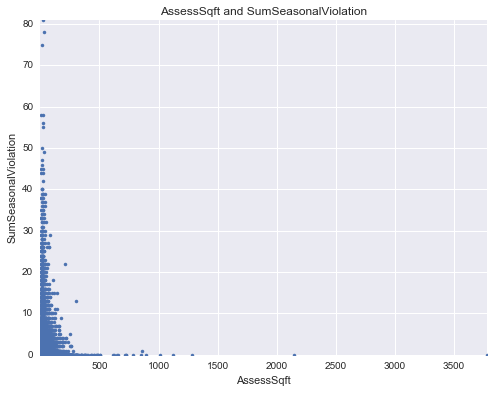

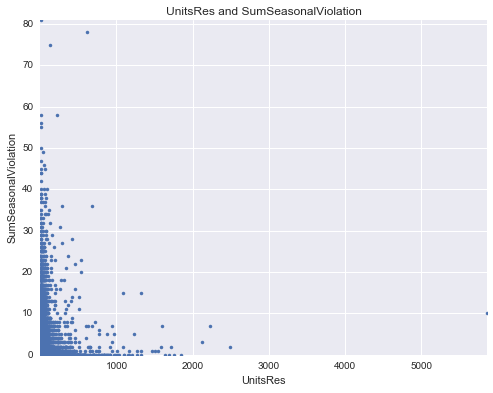

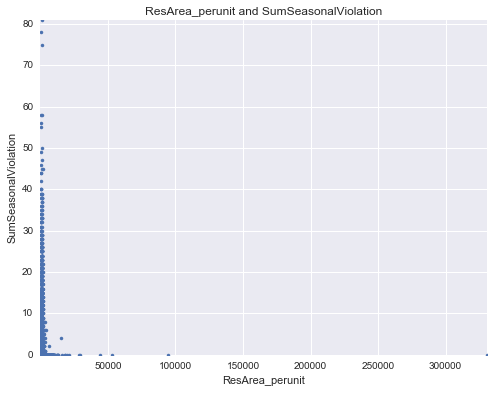

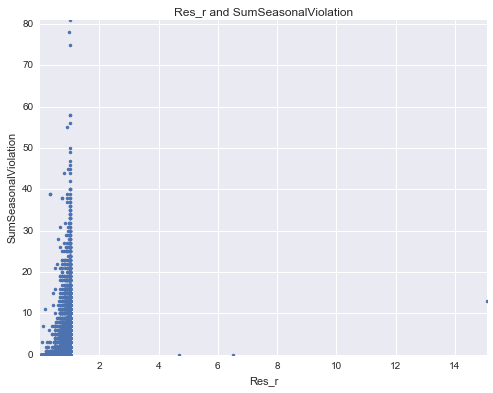

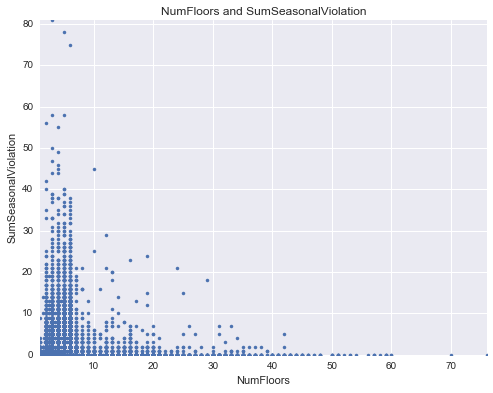

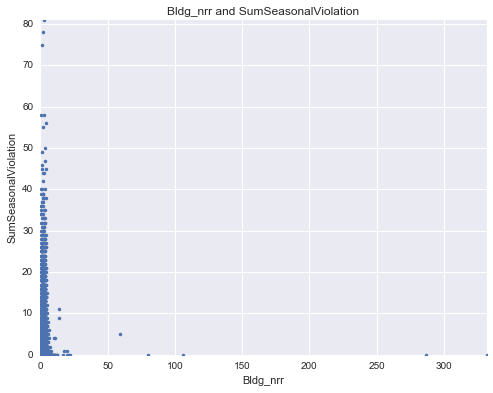

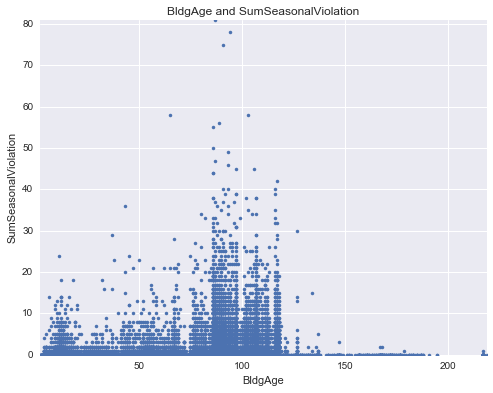

In [37]:
cols = ['AssessSqft','UnitsRes', 'ResArea_perunit','Res_r','NumFloors','Bldg_nrr',\
       'BldgAge']
for elem in cols:
    plt.figure(figsize=(8,6))
    plt.plot(dvp[elem],dvp['Sum_season_vio'], '.')
    plt.title(elem + ' and SumSeasonalViolation')
    plt.xlabel(elem)
    plt.ylabel('SumSeasonalViolation')
    plt.xlim(min(dvp[elem]),max(dvp[elem]))
    plt.ylim(min(dvp['Sum_season_vio']),max(dvp['Sum_season_vio']))

In [38]:
dvp_dropped = dvp.drop(['Avg_season_vio','Sum_season_vio'],axis=1)

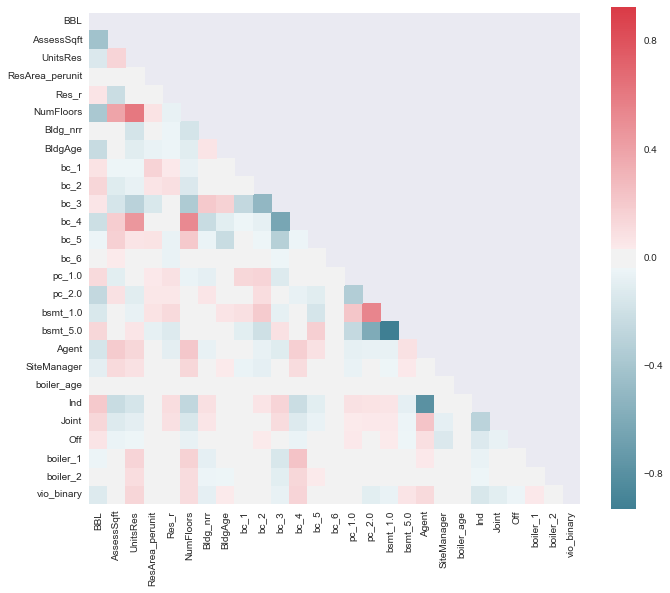

In [39]:
corr = dvp_dropped.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, ax=ax)


#### logistic regression

In [40]:
print len(dvp[dvp['vio_binary']==0])/float(len(dvp))
print len(dvp[dvp['vio_binary']==1])/float(len(dvp))

0.896659993375
0.103340006625


In [41]:
dvp.columns

Index([u'BBL', u'AssessSqft', u'UnitsRes', u'ResArea_perunit', u'Res_r',
       u'NumFloors', u'Bldg_nrr', u'BldgAge', u'bc_1', u'bc_2', u'bc_3',
       u'bc_4', u'bc_5', u'bc_6', u'pc_1.0', u'pc_2.0', u'bsmt_1.0',
       u'bsmt_5.0', u'Sum_season_vio', u'Avg_season_vio', u'Agent',
       u'SiteManager', u'boiler_age', u'Ind', u'Joint', u'Off', u'boiler_1',
       u'boiler_2', u'vio_binary'],
      dtype='object')

The percentage of correctly classified datapoints, or accuracy, can be calculated with the following formula: ACC = (TP + TN) / (TP + TN + FP + FN). The percentage of incorrectly classified datapoints over the test set can be calculated with the following formula: (FP + FN) / (TP + TN + FP + FN), or 1 - ACC.

In [42]:
X = dvp.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_1', 'bc_2', \
               'bc_3', 'bc_4', 'bc_5', 'bc_6', 'pc_1.0', 'pc_2.0', \
               'bsmt_1.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
y = dvp.loc[:,['vio_binary']]
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
for i in np.arange(1,300,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    mod = smf.Logit(y_train, X_train)
    res = mod.fit()
    is_rsquared.append(res.prsquared)
    y_pred = res.predict(X_test)
    results = pd.concat([y_test,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][1])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))
print 'Average FP: '+str(np.mean(FP))
print 'Average FN: '+str(np.mean(FN))
print 'TN: ', confusion[0][0]
print 'FN:', confusion[1][0]
print 'TP: ', confusion[1][1]
print 'FP: ', confusion[0][1]
print 'Sensitivity: '+str(confusion[1][1]/float((confusion[1][1]+confusion[1][0])))
print 'Precision: '+str(confusion[1][1]/float((confusion[1][1]+confusion[0][1])))
print confusion

Optimization terminated successfully.
         Current function value: 0.288668
         Iterations 8
         Current function value: 0.291248
         Iterations: 35


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.288912
         Iterations 8
         Current function value: 0.289511
         Iterations: 35


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.289881
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.289083
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.290387
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.287416
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.290115
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.288208
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289918
         Iterations 8
         Current function value: 0.292036
         Iterations: 35


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: 0.290001
         Iterations: 35


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.290055
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.289729
         Iterations 8
Average in sample psuedo rsquared: 0.129354228496
Average percentage of correctly classified out of sample data points: 0.896709947263
Average percentage of incorrectly classified out of sample data points: 0.103290052737
Average FP: 40.2666666667
Average FN: 4693.0
TN:  41062
FN: 4691
TP:  32
FP:  40
Sensitivity: 0.00677535464747
Precision: 0.444444444444
[[41062    40]
 [ 4691    32]]


/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.761467807019


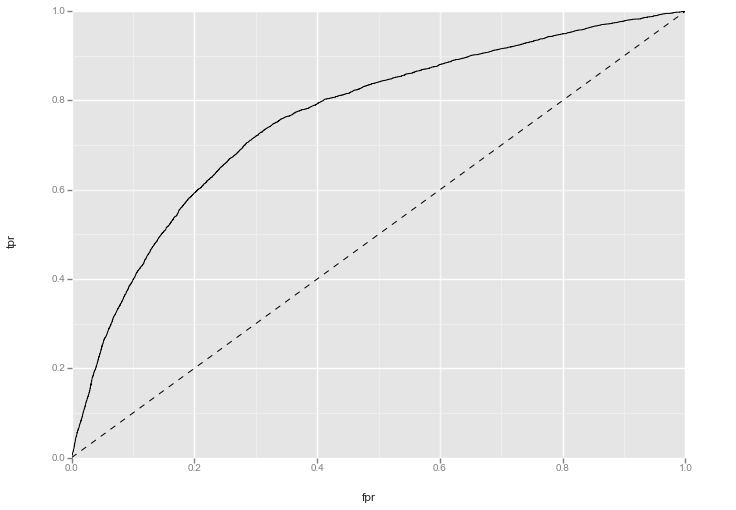

<ggplot: (357426665)>

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from ggplot import *
X = dvp.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_1', 'bc_2', \
               'bc_3', 'bc_4', 'bc_5', 'bc_6', 'pc_1.0', 'pc_2.0', \
               'bsmt_1.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
y = dvp.loc[:,['vio_binary']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
print metrics.roc_auc_score(y_test, preds)
ggplot(df, aes(x='fpr', y='tpr'))+geom_line()+geom_abline(linetype='dashed')

#### try logistic regression with undersampling the majority class

In [44]:
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
odds = []
pvalues = []
for i in np.arange(1,300,20):
    zeros = dvp[dvp['vio_binary']==0]
    sample_zeros = zeros.sample(n=len(dvp[dvp['vio_binary']==1]))
    newdf = pd.concat([dvp[dvp['vio_binary']==1], sample_zeros])
    X = newdf.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_1', 'bc_2', \
               'bc_3', 'bc_4', 'pc_1.0', 'pc_2.0', \
               'bsmt_1.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
    y = newdf.loc[:,['vio_binary']]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    mod = smf.Logit(y_train, X_train)
    res = mod.fit()
    odds.append(np.exp(res.params))
    pvalues.append(res.pvalues)
    is_rsquared.append(res.prsquared)
    y_pred = res.predict(X_test)
    results = pd.concat([y_test,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][1])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))
print 'Average FP: '+str(np.mean(FP))
print 'Average FN: '+str(np.mean(FN))
print 'TN: ', confusion[0][0]
print 'FN:', confusion[1][0]
print 'TP: ', confusion[1][1]
print 'FP: ', confusion[0][1]
print 'Sensitivity: '+str(confusion[1][1]/float((confusion[1][1]+confusion[1][0])))
print 'Precision: '+str(confusion[1][1]/float((confusion[1][1]+confusion[0][1])))
print confusion
pvaluedf = pd.concat([elem for elem in pvalues],axis=1)
pvaluedf['avg_pvalue'] = pvaluedf.mean(axis=1)
pvaluedf = pvaluedf.reset_index()
pvaluedf = pvaluedf[['index','avg_pvalue']]
pvaluedf = pvaluedf.rename(columns={'index':'variable_name'})
pvaluedf['avg_pvalue'] = pvaluedf['avg_pvalue'].map('{:,.4f}'.format)

oddsdf = pd.concat([elem for elem in odds],axis=1)
oddsdf['avg_oddsratio'] = oddsdf.mean(axis=1)
oddsdf = oddsdf.reset_index()
oddsdf = oddsdf[['index','avg_oddsratio']]
oddsdf = oddsdf.rename(columns={'index':'variable_name'})
oddsdf['avg_oddsratio'] = oddsdf['avg_oddsratio'].map('{:,.4f}'.format)

Optimization terminated successfully.
         Current function value: 0.582533
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.578051
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.582024
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579447
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.579529
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.585772
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.583496
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.581701
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.589319
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.583441
  

In [45]:
pvaluedf

,variable_name,avg_pvalue
0,AssessSqft,0.0000
1,UnitsRes,0.0000
2,ResArea_perunit,0.0000
3,Res_r,0.0063
4,NumFloors,0.0155
5,Bldg_nrr,0.0000
6,BldgAge,0.0000
7,bc_1,0.0035
8,bc_2,0.0000
9,bc_3,0.0000


In [46]:
oddsdf

,variable_name,avg_oddsratio
0,AssessSqft,0.9886
1,UnitsRes,1.0040
2,ResArea_perunit,0.9994
3,Res_r,1.5649
4,NumFloors,1.0397
5,Bldg_nrr,0.8585
6,BldgAge,1.0060
7,bc_1,2.1788
8,bc_2,3.1599
9,bc_3,2.4403


0.772478276419


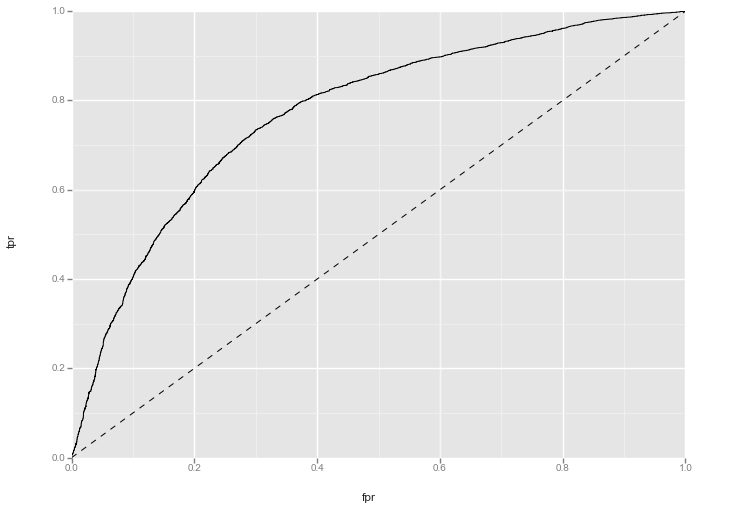

<ggplot: (376120177)>

In [47]:
zeros = dvp[dvp['vio_binary']==0]
sample_zeros = zeros.sample(n=len(dvp[dvp['vio_binary']==1]))
newdf = pd.concat([dvp[dvp['vio_binary']==1], sample_zeros])
X = newdf.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_1', 'bc_2', \
               'bc_3', 'bc_4', 'bc_5', 'bc_6', 'pc_1.0', 'pc_2.0', \
               'bsmt_1.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
y = newdf.loc[:,['vio_binary']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
clf = LogisticRegression()
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
print metrics.roc_auc_score(y_test, preds)
ggplot(df, aes(x='fpr', y='tpr'))+geom_line()+geom_abline(linetype='dashed')

#### try logistic with oversampling minority class

In [48]:
X = dvp.loc[:,['AssessSqft', 'UnitsRes', 'ResArea_perunit', 'Res_r', \
               'NumFloors', 'Bldg_nrr', 'BldgAge', 'bc_1', 'bc_2', \
               'bc_3', 'bc_4', 'bc_5', 'bc_6', 'pc_1.0', 'pc_2.0', \
               'bsmt_1.0', 'bsmt_5.0', 'Agent', 'SiteManager', \
               'boiler_age', 'Ind', 'Joint', 'Off', 'boiler_1', 'boiler_2']]
y = dvp.loc[:,['vio_binary']]
is_rsquared = []
os_acc = []
os_inacc = []
TN = []
FN = []
TP = []
FP = []
for i in np.arange(1,300,20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=i)
    sm = SMOTE(random_state=i, ratio = 1.0)
    X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
    mod = smf.Logit(y_train_res, X_train_res)
    res = mod.fit()
    is_rsquared.append(res.prsquared)
    y_pred = res.predict(X_test)
    results = pd.concat([y_test,y_pred],axis=1)
    results = results.rename(columns={0:'y_pred'})
    results['vio_pred'] = [1 if x >= 0.5 else 0 for x in y_pred]
    confusion = confusion_matrix(results['vio_binary'], results['vio_pred'])
    TN.append(confusion[0][0])
    FN.append(confusion[1][0])
    TP.append(confusion[1][1])
    FP.append(confusion[0][1])
    os_acc.append((confusion[1][1]+confusion[0][0])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
    os_inacc.append((confusion[1][0]+confusion[0][1])/float((confusion[0][0]+confusion[1][0]+confusion[1][1]+confusion[0][1])))
print 'Average in sample psuedo rsquared: '+str(np.mean(is_rsquared))
print 'Average percentage of correctly classified out of sample data points: '+str(np.mean(os_acc))
print 'Average percentage of incorrectly classified out of sample data points: '+str(np.mean(os_inacc))
print 'Average FP: '+str(np.mean(FP))
print 'Average FN: '+str(np.mean(FN))
print 'TN: ', confusion[0][0]
print 'FN:', confusion[1][0]
print 'TP: ', confusion[1][1]
print 'FP: ', confusion[0][1]
print 'Sensitivity: '+str(confusion[1][1]/float((confusion[1][1]+confusion[1][0])))
print 'Precision: '+str(confusion[1][1]/float((confusion[1][1]+confusion[0][1])))
print confusion

Optimization terminated successfully.
         Current function value: 0.571146
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.573344
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.572819
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.570111
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.570870
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.573733
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.573825
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.574410
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.571971
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.570053
  

0.765867000549


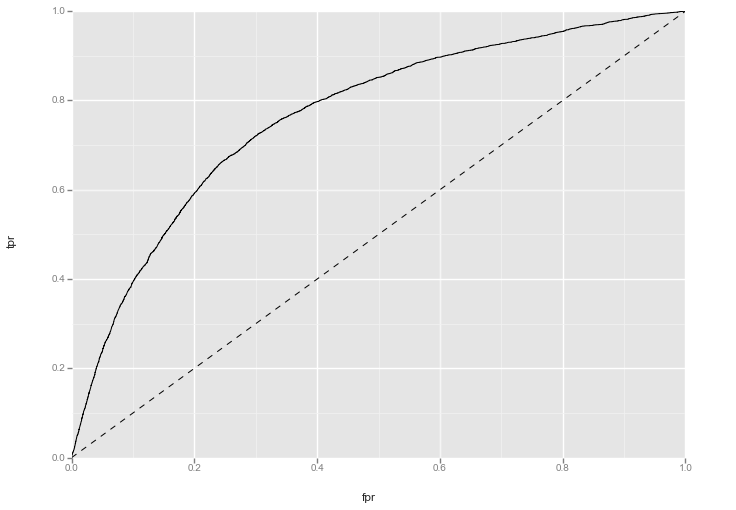

<ggplot: (357464521)>

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)
sm = SMOTE(random_state=i, ratio = 1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)
clf = LogisticRegression()
clf.fit(X_train_res, y_train_res)
preds = clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, preds)
df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
print metrics.roc_auc_score(y_test, preds)
ggplot(df, aes(x='fpr', y='tpr'))+geom_line()+geom_abline(linetype='dashed')